# JAX Quickstart

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/quickstart.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/google/jax/blob/main/docs/notebooks/quickstart.ipynb)

**JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.**

With its updated version of [Autograd](https://github.com/hips/autograd), JAX
can automatically differentiate native Python and NumPy code. It can
differentiate through a large subset of Python’s features, including loops, ifs,
recursion, and closures, and it can even take derivatives of derivatives of
derivatives. It supports reverse-mode as well as forward-mode differentiation, and the two can be composed arbitrarily
to any order.

What’s new is that JAX uses
[XLA](https://www.tensorflow.org/xla)
to compile and run your NumPy code on accelerators, like GPUs and TPUs.
Compilation happens under the hood by default, with library calls getting
just-in-time compiled and executed. But JAX even lets you just-in-time compile
your own Python functions into XLA-optimized kernels using a one-function API.
Compilation and automatic differentiation can be composed arbitrarily, so you
can express sophisticated algorithms and get maximal performance without having
to leave Python.

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap
from jax import random

## Multiplying Matrices

We'll be generating random data in the following examples. One big difference between NumPy and JAX is how you generate random numbers. For more details, see [Common Gotchas in JAX].

[Common Gotchas in JAX]: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Random-Numbers

In [2]:
key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

[-0.3721097   0.2642309  -0.18252775 -0.7368085  -0.44030353 -0.15214416
 -0.6713451  -0.590867    0.7316775   0.567302  ]


Let's dive right in and multiply two big matrices.

In [3]:
size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

1.59 ms ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


We added that `block_until_ready` because JAX uses asynchronous execution by default (see {ref}`async-dispatch`).

JAX NumPy functions work on regular NumPy arrays.

In [4]:
import numpy as np
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

17.7 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's slower because it has to transfer data to the GPU every time. You can ensure that an NDArray is backed by device memory using {func}`~jax.device_put`.

In [5]:
from jax import device_put

x = np.random.normal(size=(size, size)).astype(np.float32)
x = device_put(x)
%timeit jnp.dot(x, x.T).block_until_ready()

1.56 ms ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The output of {func}`~jax.device_put` still acts like an NDArray, but it only copies values back to the CPU when they're needed for printing, plotting, saving to disk, branching, etc. The behavior of {func}`~jax.device_put` is equivalent to the function `jit(lambda x: x)`, but it's faster.

If you have a GPU (or TPU!) these calls run on the accelerator and have the potential to be much faster than on CPU.
See {ref}`faq-jax-vs-numpy` for more comparison of performance characteristics of NumPy and JAX

JAX is much more than just a GPU-backed NumPy. It also comes with a few program transformations that are useful when writing numerical code. For now, there are three main ones:

 - {func}`~jax.jit`, for speeding up your code
 - {func}`~jax.grad`, for taking derivatives
 - {func}`~jax.vmap`, for automatic vectorization or batching.

Let's go over these, one-by-one. We'll also end up composing these in interesting ways.

## Using {func}`~jax.jit` to speed up functions

JAX runs transparently on the GPU or TPU (falling back to CPU if you don't have one). However, in the above example, JAX is dispatching kernels to the GPU one operation at a time. If we have a sequence of operations, we can use the `@jit` decorator to compile multiple operations together using [XLA](https://www.tensorflow.org/xla). Let's try that.

In [6]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()

550 µs ± 23.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can speed it up with `@jit`, which will jit-compile the first time `selu` is called and will be cached thereafter.

In [7]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

179 µs ± 118 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Taking derivatives with {func}`~jax.grad`

In addition to evaluating numerical functions, we also want to transform them. One transformation is [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). In JAX, just like in [Autograd](https://github.com/HIPS/autograd), you can compute gradients with the {func}`~jax.grad` function.

In [8]:
def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.1966118  0.10499343]


Let's verify with finite differences that our result is correct.

In [9]:
def first_finite_differences(f, x):
  eps = 1e-3
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])


print(first_finite_differences(sum_logistic, x_small))

[0.24974345 0.1965761  0.10490417]


Taking derivatives is as easy as calling {func}`~jax.grad`. {func}`~jax.grad` and {func}`~jax.jit` compose and can be mixed arbitrarily. In the above example we jitted `sum_logistic` and then took its derivative. We can go further:

In [11]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.03532532


For more advanced autodiff, you can use {func}`jax.vjp` for reverse-mode vector-Jacobian products and {func}`jax.jvp` for forward-mode Jacobian-vector products. The two can be composed arbitrarily with one another, and with other JAX transformations. Here's one way to compose them to make a function that efficiently computes full Hessian matrices:

In [12]:
from jax import jacfwd, jacrev
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))

## Auto-vectorization with {func}`~jax.vmap`

JAX has one more transformation in its API that you might find useful: {func}`~jax.vmap`, the vectorizing map. It has the familiar semantics of mapping a function along array axes, but instead of keeping the loop on the outside, it pushes the loop down into a function’s primitive operations for better performance. When composed with {func}`~jax.jit`, it can be just as fast as adding the batch dimensions by hand.

We're going to work with a simple example, and promote matrix-vector products into matrix-matrix products using {func}`~jax.vmap`. Although this is easy to do by hand in this specific case, the same technique can apply to more complicated functions.

In [13]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
  return jnp.dot(mat, v)

Given a function such as `apply_matrix`, we can loop over a batch dimension in Python, but usually the performance of doing so is poor.

In [14]:
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
2.73 ms ± 85.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


We know how to batch this operation manually. In this case, `jnp.dot` handles extra batch dimensions transparently.

In [15]:
@jit
def batched_apply_matrix(v_batched):
  return jnp.dot(v_batched, mat.T)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
158 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


However, suppose we had a more complicated function without batching support. We can use {func}`~jax.vmap` to add batching support automatically.

In [16]:
@jit
def vmap_batched_apply_matrix(v_batched):
  return vmap(apply_matrix)(v_batched)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
157 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Of course, {func}`~jax.vmap` can be arbitrarily composed with {func}`~jax.jit`, {func}`~jax.grad`, and any other JAX transformation.

## Parallelism basics

The most basic use of `jax.pmap` is completely analogous to `jax.vmap`, more examples are in the [Parallel Evaluation in JAX notebook](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/06-parallelism.ipynb).

In [17]:
import numpy as np
import jax.numpy as jnp

x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

Now, let's convert our `convolve` function into one that runs on entire batches of data. In anticipation of spreading the batch across several devices, we'll make the batch size equal to the number of devices:

In [18]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [19]:
n_devices = jax.local_device_count()
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

xs

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34],
       [35, 36, 37, 38, 39]])

In [20]:
ws

array([[2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.],
       [2., 3., 4.]])

As before, we can vectorise using `jax.vmap`:

In [21]:
jax.vmap(convolve)(xs, ws)

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)

To spread out the computation across multiple devices, just replace `jax.vmap` with `jax.pmap`:

In [22]:
jax.pmap(convolve)(xs, ws)

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)

Note that the parallelized `convolve` returns a `jax.Array`. That is because the elements of this array are sharded across all of the devices used in the parallelism. If we were to run another parallel computation, the elements would stay on their respective devices, without incurring cross-device communication costs.

In [23]:
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))

Array([[   78.,   138.,   198.],
       [ 1188.,  1383.,  1578.],
       [ 3648.,  3978.,  4308.],
       [ 7458.,  7923.,  8388.],
       [12618., 13218., 13818.],
       [19128., 19863., 20598.],
       [26988., 27858., 28728.],
       [36198., 37203., 38208.]], dtype=float32)

The outputs of the inner `jax.pmap(convolve)` never left their devices when being fed into the outer `jax.pmap(convolve)`.

## Your first JAX training loop

We still have much to learn about JAX, but you already know enough to understand how we can use JAX to build a simple training loop.

To keep things simple, we'll start with a linear regression.

Our data is sampled according to $y = w_{true} x + b_{true} + \epsilon$.

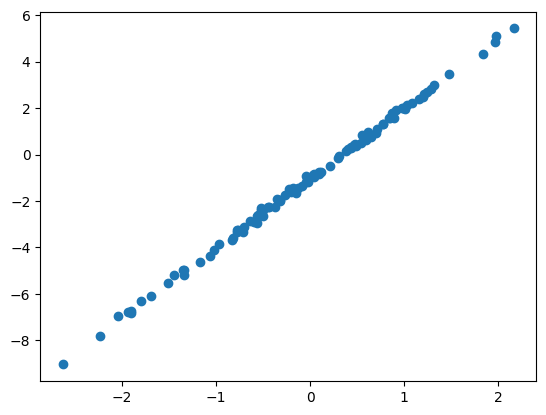

In [25]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

Therefore, our model is $\hat y(x; \theta) = wx + b$.

We will use a single array, `theta = [w, b]` to house both parameters:

In [26]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

The loss function is $J(x, y; \theta) = (\hat y - y)^2$.

In [27]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

How do we optimize a loss function? Using gradient descent. At each update step, we will find the gradient of the loss w.r.t. the parameters, and take a small step in the direction of steepest descent:

$\theta_{new} = \theta - 0.1 (\nabla_\theta J) (x, y; \theta)$

In [28]:
@jit
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

In JAX, it's common to define an `update()` function that is called every step, taking the current parameters as input and returning the new parameters. This is a natural consequence of JAX's functional nature, and is explained in more detail in [The Problem of State](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb).

This function can then be JIT-compiled in its entirety for maximum efficiency. The next guide will explain exactly how `jax.jit` works, but if you want to, you can try adding `@jax.jit` before the `update()` definition, and see how the training loop below runs much faster.

w: 3.00, b: -1.01
CPU times: user 1.54 s, sys: 118 ms, total: 1.66 s
Wall time: 1.22 s


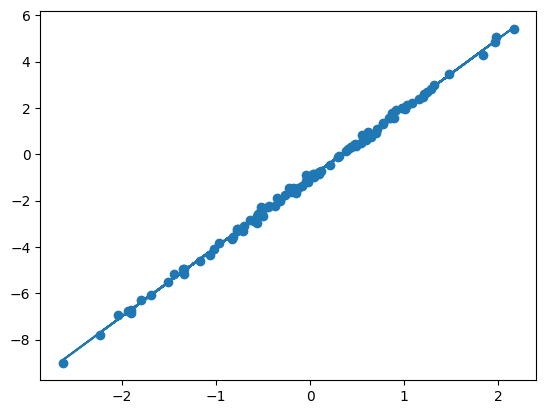

In [29]:
%%time
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

As you will see going through these guides, this basic recipe underlies almost all training loops you'll see implemented in JAX. The main difference between this example and real training loops is the simplicity of our model: that allows us to use a single array to house all our parameters. We cover managing more parameters in the later [pytree guide](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb). Feel free to skip forward to that guide now to see how to manually define and train a simple MLP in JAX.

## Aside: hosts and devices in JAX

When running on TPU, the idea of a 'host' becomes important. A host is the CPU that manages several devices. A single host can only manage so many devices (usually 8), so when running very large parallel programs, multiple hosts are needed, and some finesse is required to manage them.

## (Optional) Parallel Training Example

Here's an example of a regression training loop with data parallelism, where each batch is split into sub-batches which are evaluated on separate devices.

There are two places to pay attention to:
* the `update()` function
* the replication of parameters and splitting of data across devices.

If this example is too confusing, you can find the same example, but without parallelism, in the next notebook, [State in JAX](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb). Once that example makes sense, you can compare the differences to understand how parallelism changes the picture.

In [30]:
from typing import NamedTuple
import functools

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss_fn(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * xs + params.bias
  return jnp.mean((pred - ys) ** 2)

LEARNING_RATE = 0.005

# So far, the code is identical to the single-device case. Here's what's new:


# Remember that the `axis_name` is just an arbitrary string label used
# to later tell `jax.lax.pmean` which axis to reduce over. Here, we call it
# 'num_devices', but could have used anything, so long as `pmean` used the same.
@functools.partial(jax.pmap, axis_name='num_devices')
def update(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> tuple[Params, jnp.ndarray]:
  """Performs one SGD update step on params using the given data."""

  # Compute the gradients on the given minibatch (individually on each device).
  loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

  # Combine the gradient across all devices (by taking their mean).
  grads = jax.lax.pmean(grads, axis_name='num_devices')

  # Also combine the loss. Unnecessary for the update, but useful for logging.
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Each device performs its own update, but since we start with the same params
  # and synchronise gradients, the params stay in sync.
  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grads)

  return new_params, loss

Here's how `update()` works:

Undecorated and without the `pmean`s, `update()` takes data tensors of shape `[batch, ...]`, computes the loss function on that batch and evaluates its gradients.

We want to spread the `batch` dimension across all available devices. To do that, we add a new axis using `pmap`. The arguments to the decorated `update()` thus need to have shape `[num_devices, batch_per_device, ...]`. So, to call the new `update()`, we'll need to reshape data batches so that what used to be `batch` is reshaped to `[num_devices, batch_per_device]`. That's what `split()` does below. Additionally, we'll need to replicate our model parameters, adding the `num_devices` axis. This reshaping is how a pmapped function knows which devices to send which data.

At some point during the update step, we need to combine the gradients computed by each device -- otherwise, the updates performed by each device would be different. That's why we use `jax.lax.pmean` to compute the mean across the `num_devices` axis, giving us the average gradient of the batch. That average gradient is what we use to compute the update.

Aside on naming: here, we use `num_devices` for the `axis_name` for didactic clarity while introducing `jax.pmap`. However, in some sense that is tautologous: any axis introduced by a pmap will represent a number of devices. Therefore, it's common to see the axis be named something semantically meaningful, like `batch`, `data` (signifying data parallelism) or `model` (signifying model parallelism).

In [31]:
# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

# Initialise parameters and replicate across devices.
params = init(jax.random.PRNGKey(123))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)

So far, we've just constructed arrays with an additional leading dimension. The params are all still on the host (CPU). `pmap` will communicate them to the devices when `update()` is first called, and each copy will stay on its own device subsequently.

In [32]:
type(replicated_params.weight)

jaxlib.xla_extension.ArrayImpl

The params will become a jax.Array when they are returned by our pmapped `update()` (see further down).

We do the same to the data:

In [33]:
def split(arr):
  """Splits the first axis of `arr` evenly across the number of devices."""
  return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

# Reshape xs and ys for the pmapped `update()`.
x_split = split(xs)
y_split = split(ys)

type(x_split)

numpy.ndarray

The data is just a reshaped vanilla NumPy array. Hence, it cannot be anywhere but on the host, as NumPy runs on CPU only. Since we never modify it, it will get sent to the device at each `update` call, like in a real pipeline where data is typically streamed from CPU to the device at each step.

In [34]:
def type_after_update(name, obj):
  print(f"after first `update()`, `{name}` is a", type(obj))

# Actual training loop.
for i in range(1000):

  # This is where the params and data gets communicated to devices:
  replicated_params, loss = update(replicated_params, x_split, y_split)

  # The returned `replicated_params` and `loss` are now both jax.Arrays,
  # indicating that they're on the devices.
  # `x_split`, of course, remains a NumPy array on the host.
  if i == 0:
    type_after_update('replicated_params.weight', replicated_params.weight)
    type_after_update('loss', loss)
    type_after_update('x_split', x_split)

  if i % 100 == 0:
    # Note that loss is actually an array of shape [num_devices], with identical
    # entries, because each device returns its copy of the loss.
    # So, we take the first element to print it.
    print(f"Step {i:3d}, loss: {loss[0]:.3f}")


# Plot results.

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))

after first `update()`, `replicated_params.weight` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `loss` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `x_split` is a <class 'numpy.ndarray'>
Step   0, loss: 4.825
Step 100, loss: 0.975
Step 200, loss: 0.360
Step 300, loss: 0.261
Step 400, loss: 0.245
Step 500, loss: 0.243
Step 600, loss: 0.242
Step 700, loss: 0.242
Step 800, loss: 0.242
Step 900, loss: 0.242


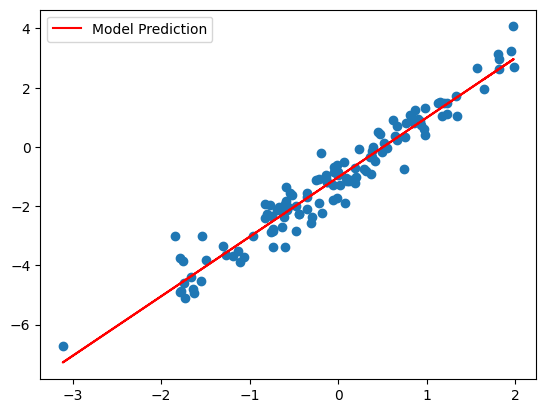

In [35]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend()
plt.show()

In [36]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

When running on CPU you can always emulate an arbitrary number of devices with a nifty `--xla_force_host_platform_device_count` XLA flag, e.g. by executing the following before importing JAX:
```python
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'
jax.devices()
```
```
[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]
```
This is especially useful for debugging and testing locally or even for prototyping in Colab since a CPU runtime is faster to (re-)start.

This is just a taste of what JAX can do. We're really excited to see what you do with it!